In [1]:
import numpy as np
import torch 
from torch.utils.data import DataLoader, random_split
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import os
import random
import copy
from collections import defaultdict
import time
import pickle

In [2]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 kB 791.0 kB/s eta 0:00:0000:0100:01


In [4]:
from torchattacks import *

## 1. Data Preprocessing

In [5]:
def preprocessing(main_folder_path):
    # list of folders in the main folder
    listdir = sorted(os.listdir(main_folder_path))
    
    # Image Transformation
    mean = [0.485, 0.456, 0.406] # mean of image tensor
    std = [0.229, 0.224, 0.225]  # standard devisation of image tensor
    normalize_stat = (mean, std)
    size = 224

    transform = T.Compose([
        T.Resize(size),
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize(*normalize_stat)
    ])

    dataset = ImageFolder(main_folder_path, transform=transform)
    classes = dataset.classes

    return dataset, classes

In [6]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
dataset, classes = preprocessing(main_folder_path)

print("Total dataset size: ", len(dataset))
print("Number of classes: ", len(classes))

Total dataset size:  17534
Number of classes:  105


In [7]:
def dataloader(dataset, classes, train_batch_size, test_batch_size, num_clients):
    torch.manual_seed(42)
    
    # 70% to 30% train to test
    num_val = int(len(dataset) * 0.3)
    num_train = len(dataset) - num_val
    
    # 1. Train and Validation Data
    train_data, test_data = random_split(dataset, [num_train, num_val])
    
    # save train_data size (n)
    n = len(train_data)
    
    # Partition data for federated learning
    train_loader_list = []
    
    # nk / n list
    nk_n_list = []
    
    # Client ID: corresponding train_loader
    client_loader_dict = {}
    
    # Split train dataset
    total_train_size = len(train_data)
    examples_per_client = total_train_size // num_clients
    client_datasets = random_split(train_data, [min(i + examples_per_client, 
               total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
    
    # Remove the left over (4)
    client_datasets = client_datasets[:num_clients]
    
    for idx, dataset in enumerate(client_datasets):
        print(f"Client_id {idx} data size: {len(dataset)}")
        
    print("")
    
    # Save dataloader for each
    for client_id, client_data in enumerate(client_datasets):
        # Save nk / n
        nk_n = len(client_data) / len(train_data)
        nk_n_list.append(nk_n)
        
        train_loader = DataLoader(client_data, batch_size=train_batch_size, shuffle=True, pin_memory=False, num_workers=3)
        train_loader_list.append(train_loader)
        client_loader_dict[client_id] = train_loader
    
    # Train and Validation Dataloader
    loader_idx = 0
    for key, _ in client_loader_dict.items():
        client_loader_dict[key] = train_loader_list[loader_idx]
        loader_idx += 1
    
    test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, pin_memory=False, num_workers=3)
    
    return train_loader_list, client_loader_dict, test_loader, test_data, nk_n_list

In [8]:
def denormal(image):
    image = image.numpy().transpose(1, 2, 0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def denormalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # 3, H, W, B
    ten = x.clone().permute(1, 2, 3, 0)
    for t, m, s in zip(ten, mean, std):
        t.mul_(s).add_(m)
    
    # B, 3, H, W
    return torch.clamp(ten, 0, 1).permute(3, 0, 1, 2)

Size of first image:  torch.Size([3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

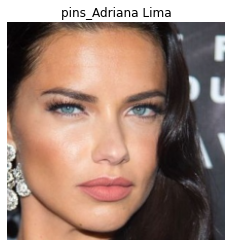

In [9]:
idx = 1
image, label = dataset[idx]

print("Size of first image: ", dataset[0][0].size())
plt.imshow(denormal(image))
plt.title(dataset.classes[label])
plt.axis('off')

In [10]:
# model = torchvision.models.resnet34(pretrained=True)
# atk = FGSM(model, eps=0)
# images, labels = iter(test_loader).next()
# adv_images = atk(images, labels)

# plt.imshow(denormal(adv_images[10]))
# plt.title(dataset.classes[labels[10]])
# plt.axis('off')

In [11]:
# # model = torchvision.models.resnet34(pretrained=True)
# atk = FGSM(model, eps=8/255)
# images, labels = iter(test_loader).next()
# adv_images = atk(images, labels)

# plt.imshow(denormal(adv_images[10]))
# plt.title(dataset.classes[labels[10]])
# plt.axis('off')

## 2. Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from glob import glob
from tqdm.notebook import tqdm

In [13]:
class black_box_model(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.resnet34 = models.resnet34(True)
        self.features = nn.Sequential(*list(self.resnet34.children())[:-1])
        # Replace last layer
        self.classifier = nn.Sequential(nn.Flatten(),
                                         nn.Linear(self.resnet34.fc.in_features, num_classes))

    def forward(self, x):
        x = self.features(x)
        y = self.classifier(x)
        return y
    
    def summary(self, input_size):
        return summary(self, input_size)

In [14]:
# class white_box_model(nn.Module):
#     def __init__(self, num_classes, dropout, pretrained=True):
#         super().__init__()
#         # Use a pretrained model
#         self.dropout = dropout
#         self.alexnet = models.alexnet(True)
#         self.features = nn.Sequential(*list(self.alexnet.children())[:-1])
        
#         # Replace last layer
#         self.classifier = nn.Sequential(
#             nn.Dropout(p=self.dropout),
#             nn.Linear(6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=self.dropout),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         y = self.classifier(x)
#         return y
    
#     def summary(self, input_size):
#         return summary(self, input_size)

In [15]:
# class white_box_model(nn.Module):
#     def __init__(self, num_classes, pretrained=True):
#         super().__init__()
#         # Use a pretrained model
#         self.resnet50 = models.resnet50(True)
#         self.features = nn.Sequential(*list(self.resnet50.children())[:-1])
#         # Replace last layer
#         self.classifier = nn.Sequential(nn.Flatten(),
#                                          nn.Linear(self.resnet50.fc.in_features, num_classes))

#     def forward(self, x):
#         x = self.features(x)
#         y = self.classifier(x)
#         return y
    
#     def summary(self, input_size):
#         return summary(self, input_size)

In [16]:
# models.resnet34(True).fc.in_features

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

512

In [17]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
dataset, classes = preprocessing(main_folder_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(classes)

global_model = black_box_model(num_classes=num_classes).to(device)
# global_model.summary((3, 32, 32))

In [18]:
# main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
# dataset, classes = preprocessing(main_folder_path)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# num_classes = len(classes)

# model = white_box_model(num_classes=num_classes).to(device)
# # model.summary((3, 96, 96))

## 3. Federated Learning

In [19]:
# # Federated Averaging Algorithm (Non-IID)
# def fedAvg(w, nk_n_list, client_id_selected):
    
#     print("")
#     print("Averaging client_id list: ", client_id_selected)
    
#     first_id = client_id_selected[0]
#     w_avg = copy.deepcopy(w[first_id])
    
#     # Update first weight parameter
#     for k in w_avg.keys():
#         nk_n = nk_n_list[first_id]
#         w_avg[k] = w_avg[k] + (nk_n * w[first_id][k])
    
#     # Remove the updated id weight
#     client_id_selected.remove(first_id)
    
#     print("After removing first index: ", client_id_selected)
#     print("")
    
#     # Use selected client's weight parameters
#     for k in w_avg.keys():
#         for i in client_id_selected: 
#             nk_n = nk_n_list[i]
#             w_avg[k] = w_avg[k] + (nk_n * w[i][k])
        
#         w_avg[k] = torch.div(w_avg[k], len(w))
    
#     return w_avg

In [20]:
# FedAvg (iid-setting)
from collections import OrderedDict

def fedAvg(client_model_list, nk_n_list):
    new_params = OrderedDict()
    
    n = len(client_model_list)  # number of clients
    
    for client_model in client_model_list:
        local_param = client_model.state_dict()  # get current parameters of one client
        for k, v in local_param.items():
            new_params[k] = new_params.get(k, 0) + v / n
    
    return new_params

## 4. Clean Training and Evaluation

In [21]:
pip install torchattacks

Note: you may need to restart the kernel to use updated packages.


In [22]:
from torchattacks import *

In [23]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

# Code Referance: https://www.kaggle.com/code/pezhmansamadi/facerecognition-torch-resnet34

def local_train(clean_train_batch_ratio, atk, attack_id_selected, white_model, client_id, e, local_epochs, local_model, train_loader, device, criterion, optimizer):
    torch.cuda.empty_cache()
    local_model.train(True)
    torch.set_grad_enabled(True)
    
    if client_id in attack_id_selected:
        # Create adversarial example
        print(atk)
        print("Adversarial Training on current device")
    
    total = 0
    correct = 0
    local_loss = 0.0
    local_acc = 0
    
    tq_batch = tqdm(train_loader, total=len(train_loader))
    for idx, (images, labels) in enumerate(tq_batch):
        images = images.to(device)
        labels = labels.to(device)
        
        ratio = int(len(train_loader) * clean_train_batch_ratio)
        
        # Attack if current id is the selected id
        if (client_id in attack_id_selected) and (idx >= ratio):
            # print("Half way")
            # Create adversarial example
            images = atk(images, labels)
            
        optimizer.zero_grad()
        outs = local_model(images)
        _, preds = torch.max(outs, 1)
        
        # outs = torch.exp(outs)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        local_loss += loss.item()
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        local_acc += float(correct) / total
        
        tq_batch.set_description(f'Local Epoch [{e + 1}/{local_epochs}]')
        tq_batch.set_postfix_str('Local loss = {:.4f} ; Local acc = {:.4f} '.format(loss.item(), float(correct) / total))
    
    # Average loss and acc of the training batch
    local_acc = local_acc / len(train_loader)
    local_loss = local_loss / len(train_loader)
    local_w = local_model.state_dict()

    return local_model, local_loss, local_w, local_acc

def global_evaluate(global_model, test_loader, criterion, device):
    torch.cuda.empty_cache()
    global_model.eval()
    
    total = 0
    glob_loss = 0
    glob_acc = 0
    correct = 0
    
    tq_batch = tqdm(test_loader, total=len(test_loader), leave=False)
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)

        outputs = global_model(images)
        loss = criterion(outputs, labels)
        glob_loss += loss.item()
        
        _, preds = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        
        glob_acc += float(correct) / total
        batch_acc = float(correct) / total
        
        tq_batch.set_postfix_str('Global loss = {:.4f} ; Global acc = {:.4f} '.format(loss.item(), batch_acc))
    
    # Average global loss and acc of the batch
    glob_loss = glob_loss / len(test_loader)
    glob_acc = glob_acc / len(test_loader)

    return glob_acc, glob_loss

In [24]:
def robust_evaluate(atk, white_model, global_model, test_loader, criterion, device):
    torch.cuda.empty_cache()
    global_model.eval()
    
    total = 0
    robust_loss = 0
    robust_acc = 0
    correct = 0
    
    tq_batch = tqdm(test_loader, total=len(test_loader), leave=False)
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        # Create adversarial example
        images = atk(images, labels)

        outputs = global_model(images)
        loss = criterion(outputs, labels)
        robust_loss += loss.item()
        
        _, preds = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        
        robust_acc += float(correct) / total
        batch_acc = float(correct) / total
        
        tq_batch.set_postfix_str('Robust loss = {:.4f} ; Robust acc = {:.4f} '.format(loss.item(), batch_acc))
    
    # Average global loss and acc of the batch
    robust_loss = robust_loss / len(test_loader)
    robust_acc = robust_acc / len(test_loader)

    return robust_acc, robust_loss

In [25]:
def federated_learning(clean_train_batch_ratio, num_attacks, white_model, num_selected, num_rounds, num_clients, num_local_epochs, global_model, client_model_list, client_loader_dict, device, nk_n_list):
    torch.cuda.empty_cache()
    
    id_loss_dict = defaultdict(list)
    id_acc_dict = defaultdict(list)
    update_count_dict = {}
    adv_train_dict = {}
    
    num_client_list = [i for i in range(num_clients)] # Total client id list
    
    #############################################
    # Method 2
#     attack_id_selected = random.sample(num_client_list, k=num_attacks) # Clients to be adversarially trained
#     print("Adversarial Training id selected: ", attack_id_selected)
#     for cli in attack_id_selected: 
#         adv_train_dict[cli] = 0
    #############################################    
    
    for _client in num_client_list:
        update_count_dict[_client] = 0
        # ***************************************
        # Method_1
        adv_train_dict[_client] = 0 
        # ***************************************

    
    local_w_list = [None for i in range(num_clients)]
    local_loss_list = [100 for i in range(num_clients)]
    
    glob_acc_list = []
    glob_loss_list = []
    robust_acc_list = []
    robust_loss_list = []
    
    criterion = nn.CrossEntropyLoss()
    
    # Black-box model setting
    # Use second party pre-trained model to create the adversarial example
#     atk = FGSM(white_model, eps=8/255)
    atk = FFGSM(white_model, eps=8/255, alpha=10/255) # *
#     atk = DeepFool(white_model, steps=100)
#     atk = Square(white_model, eps=8/255) # *
#     atk = PGD(white_model, eps=8/255, alpha=2/225, steps=10, random_start=True)
    
    # For each round
    start_time = time.time()
    for each_round in tqdm(range(num_rounds)):
        # Randomly selected client id "EACH ROUND"        
        # client_id_selected = num_client_list
        client_id_selected = random.sample(num_client_list, k=num_selected)   # Clients to be trained
        
        # ***************************************
        # Method_1
        attack_id_selected = random.sample(client_id_selected, k=num_attacks) # Clients to be adversarially trained (select within client to be trained)
        # ***************************************
        
        print("Selected client_id: ", client_id_selected)
        print("Adversarial Training id selected: ", attack_id_selected)
        
        # 1. Increase count for number of updates
        # 2. Increase count for adv_trained client id
        for _id in client_id_selected:
            update_count_dict[_id] += 1
            
            #############################################
#             # Method_2
#             if _id in attack_id_selected: 
#                 adv_train_dict[_id] += 1
            #############################################
        
        # ***************************************
        # Method_1
        for __id in attack_id_selected: 
            adv_train_dict[__id] += 1
        # ***************************************
        
        # For each client
        start_time = time.time()
        client_count = 1
        for client_id in tqdm(client_id_selected):
            print("")
            print(f"Updating [client_id]: {client_id}")
            print("")
            local_model = client_model_list[client_id]
            local_dataloader = client_loader_dict[client_id]
            
            learning_rate = 0.05
            optimizer = torch.optim.SGD(local_model.parameters(), lr=learning_rate)
            
            # For each local epoch for each client
            for e in tqdm(range(num_local_epochs)):
                # Train local client models
                local_updated_model, new_local_loss, local_w, local_acc = local_train(
                                                                                      clean_train_batch_ratio,
                                                                                      atk,
                                                                                      attack_id_selected, 
                                                                                      white_model,
                                                                                      client_id,
                                                                                      e, 
                                                                                      num_local_epochs, 
                                                                                      local_model, 
                                                                                      local_dataloader, 
                                                                                      device, 
                                                                                      criterion, 
                                                                                      optimizer)
                current_loss = local_loss_list[client_id]
                
                # Save loss & acc for each client id
                id_loss_dict[client_id].append(new_local_loss)
                id_acc_dict[client_id].append(local_acc)
                
                # Append new local_loss and local_weight
                local_loss_list[client_id] = new_local_loss
                local_w_list[client_id] = local_w 
                
                print(f"[rounds]: {each_round + 1}/{num_rounds} - [client_count]: {client_count}/{num_selected} - [local_epoch]: {e+1}/{num_local_epochs} - [local_loss]: {new_local_loss} - [local_acc]: {local_acc*100}%")
            
            client_count += 1
            
        # Federaed Averaging
        # new_glob_w = fedAvg(local_w_list, nk_n_list, client_id_selected)
        new_glob_w = fedAvg(client_model_list, nk_n_list)
        global_model.load_state_dict(new_glob_w)
        
        # Send new global model back to clients
        print("")
        print("Sending global model weight to local client models...")
        print("")
        for loc_model in client_model_list:
            loc_model.load_state_dict(new_glob_w)
        
        # Evaluate Global Model
        glob_acc, glob_loss = global_evaluate(global_model, test_loader, criterion, device)
        robust_acc, robust_loss = robust_evaluate(atk, white_model, global_model, test_loader, criterion, device)
        
        glob_acc_list.append(glob_acc*100)
        glob_loss_list.append(glob_loss)
        robust_acc_list.append(robust_acc*100)
        robust_loss_list.append(robust_loss)
        
        print("")
        print("*"*100)
        print("")
        print(f"[rounds]: {each_round + 1}/{num_rounds} - [global_loss]: {glob_loss} - [global_acc]: {glob_acc*100} %")
        print(f"[rounds]: {each_round + 1}/{num_rounds} - [robust_loss]: {robust_loss} - [robust_acc]: {robust_acc*100} %")
        print("")
        print("*"*100)
        print("")
    
    # Show number of updates for each client
    print("")
    for __id, count in update_count_dict.items():
        print("Client {} updated count: {}".format(__id, count))
    print("")
    
    # Adversarial Training Count
    print("")
    for _id, count in adv_train_dict.items():
        print("Client {} adversarial training count: {}".format(_id, count))
    print("")
    
    # Total time taken
    print("Time taken = {:.4f} minutes".format((time.time() - start_time) / 60))
    
    # Save Current Model
    pickle.dump(global_model, open('global_model.pkl', 'wb'))
    
    return global_model, glob_acc_list, robust_acc_list, glob_loss_list, robust_loss_list, id_loss_dict

In [37]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
   
num_clients = 5
train_batch_size = 64
test_batch_size = 64

dataset, classes = preprocessing(main_folder_path=main_folder_path)
train_loader_list, client_loader_dict, test_loader, _, nk_n_list = dataloader(dataset, classes, train_batch_size, test_batch_size, num_clients)

for idx, dt in client_loader_dict.items():
    print(f'Client {idx} dataloader size: {len(dt)}')

print("")
print("Test dataloader size: ", len(test_loader))

Client_id 0 data size: 2454
Client_id 1 data size: 2454
Client_id 2 data size: 2454
Client_id 3 data size: 2454
Client_id 4 data size: 2454

Client 0 dataloader size: 39
Client 1 dataloader size: 39
Client 2 dataloader size: 39
Client 3 dataloader size: 39
Client 4 dataloader size: 39

Test dataloader size:  83


In [38]:
# num_selected = num_clients only for iid setting
num_selected = 4
num_attack = 3
num_rounds = 10
num_local_epochs = 5

clean_train_batch_ratio = 0.75

print("Total number of clients: ", num_clients)
print("No. client selected each round: ", num_selected)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = black_box_model(num_classes=num_classes).to(device)
client_model_list = [black_box_model(num_classes=num_classes).to(device) for _ in range(num_clients)]

# Model used to create adversarial examples
# Resnet-50
# white_model = white_box_model(num_classes=num_classes).to(device)

# White-box models: Alexnet()
white_model = models.alexnet(pretrained=True).to(device)
start_time = time.time()
global_model, glob_acc_list, robust_acc_list, glob_loss_list, robust_loss_list, id_loss_dict = federated_learning(clean_train_batch_ratio,
                                                                                                                  num_attack,
                                                                                                                  white_model,
                                                                                                                  num_selected,
                                                                                                                  num_rounds, 
                                                                                                                  num_clients, 
                                                                                                                  num_local_epochs, 
                                                                                                                  global_model, 
                                                                                                                  client_model_list, 
                                                                                                                  client_loader_dict, 
                                                                                                                  device,
                                                                                                                  nk_n_list)

print("Time taken = {:.4f} minutes".format((time.time() - start_time) / 60))

Total number of clients:  5
No. client selected each round:  4


  0%|          | 0/10 [00:00<?, ?it/s]

Selected client_id:  [1, 3, 0, 2]
Adversarial Training id selected:  [2, 0, 1]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 4.468918286837065 - [local_acc]: 2.77734273440247%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 3.3622006208468704 - [local_acc]: 21.541142402463155%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 2.394925682972639 - [local_acc]: 50.11524938128152%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 1.5921786152399504 - [local_acc]: 72.71452769849326%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.9537098896809113 - [local_acc]: 88.75395350876502%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 4.394402510080582 - [local_acc]: 3.1144627217324796%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 2.9709288646013308 - [local_acc]: 30.476346771375734%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 1.760865107560769 - [local_acc]: 65.96654428331038%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.8270136423600025 - [local_acc]: 91.64488849877256%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.31995044151941937 - [local_acc]: 99.25931977558015%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 4.466777275770139 - [local_acc]: 2.1208667330915087%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 3.3341125524961033 - [local_acc]: 22.941451037831307%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 2.4003362319408317 - [local_acc]: 51.73225498392402%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 1.5967374275892208 - [local_acc]: 72.83814457845685%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.9790184069902469 - [local_acc]: 88.26711459081832%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 4.483858059614133 - [local_acc]: 2.069688384040369%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 3.345233758290609 - [local_acc]: 24.355719515002704%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 2.3989963989991407 - [local_acc]: 48.89328181321167%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 1.5807947562291071 - [local_acc]: 74.17912328873898%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.9969858955114316 - [local_acc]: 88.679716145713%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 1/10 - [global_loss]: 4.011716601360275 - [global_acc]: 10.282302271329042 %
[rounds]: 1/10 - [robust_loss]: 4.065866582364921 - [robust_acc]: 10.1282217192371 %

****************************************************************************************************

Selected client_id:  [1, 2, 3, 0]
Adversarial Training id selected:  [1, 0, 2]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 3.0150099778786683 - [local_acc]: 30.610046005625346%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 1.9228002505424695 - [local_acc]: 61.018793723934635%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 1.1416559677857618 - [local_acc]: 82.7078538253314%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.6461299436214643 - [local_acc]: 94.07889076839172%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.42198481124181014 - [local_acc]: 97.2917072185577%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 2.995456371551905 - [local_acc]: 30.5172451651872%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 1.9174870925071912 - [local_acc]: 57.54117365632163%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 1.1789432274989593 - [local_acc]: 80.796003254659%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.6626126093742175 - [local_acc]: 93.82105273724295%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.39663212880110127 - [local_acc]: 97.77703410653098%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 2.8513286052606044 - [local_acc]: 35.654965824411725%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 1.5393110941617916 - [local_acc]: 71.16904856001302%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.6782844762007395 - [local_acc]: 92.76188448810558%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.2514008933152908 - [local_acc]: 99.51030607827266%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.10839216907819112 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 3.02958511083554 - [local_acc]: 29.737728582528945%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 1.9618068841787486 - [local_acc]: 58.27304344343819%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 1.187251288157243 - [local_acc]: 82.69564052152431%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.6935174220647568 - [local_acc]: 91.69512551036067%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.4207318050739093 - [local_acc]: 98.44226846478514%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 2/10 - [global_loss]: 2.7462690853210816 - [global_acc]: 31.15034340485434 %
[rounds]: 2/10 - [robust_loss]: 2.7291817578924706 - [robust_acc]: 36.646723878993996 %

****************************************************************************************************

Selected client_id:  [4, 2, 1, 3]
Adversarial Training id selected:  [2, 1, 3]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 1.6543051524040027 - [local_acc]: 58.082935302132675%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.5547565473959997 - [local_acc]: 90.10277859064561%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.15216859850363854 - [local_acc]: 99.71346040759474%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.06768800958226888 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.04510483336754334 - [local_acc]: 100.0%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 1.3012971878051758 - [local_acc]: 77.67806889812255%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.6279467776035651 - [local_acc]: 90.74182387486968%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.35313441298710996 - [local_acc]: 96.85363490822357%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.22466418070670885 - [local_acc]: 98.5293071288597%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.1432167071944628 - [local_acc]: 99.36343668317747%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 1.3334150772828322 - [local_acc]: 77.53727455232935%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.6316723128159841 - [local_acc]: 92.50302690160063%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.3257559346847045 - [local_acc]: 96.25793479495603%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.1800486737718949 - [local_acc]: 99.68685686835062%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.1501799201927124 - [local_acc]: 99.69680309282731%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 1.3904656981810546 - [local_acc]: 77.67993246059834%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.6992429204476185 - [local_acc]: 89.07393711276829%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.4111045335347836 - [local_acc]: 97.9253479328203%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.2858751511726624 - [local_acc]: 97.30642254939781%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.21450148799862617 - [local_acc]: 99.04280541056536%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 3/10 - [global_loss]: 1.7921932547925465 - [global_acc]: 54.114752652291564 %
[rounds]: 3/10 - [robust_loss]: 2.013914465904236 - [robust_acc]: 49.56473375963848 %

****************************************************************************************************

Selected client_id:  [2, 3, 0, 1]
Adversarial Training id selected:  [0, 1, 2]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.6350549451815777 - [local_acc]: 92.44758581908931%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.34477694924825275 - [local_acc]: 96.5134934509694%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.1949865559163766 - [local_acc]: 97.90765424594949%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.1210142725553268 - [local_acc]: 99.66202865151371%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.098449768164219 - [local_acc]: 99.87101794986376%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.44075605502495396 - [local_acc]: 92.44753993125227%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.10987365102538696 - [local_acc]: 98.90692411681728%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.03852736663359862 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.02494647755072667 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.020583983821173508 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 1.0363044914526818 - [local_acc]: 81.54950318881473%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.4838215108865347 - [local_acc]: 94.05724702643758%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.2758905289646907 - [local_acc]: 97.83086373149914%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.18179371695105845 - [local_acc]: 98.86598281399642%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.1227941157726141 - [local_acc]: 99.72492763972039%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.6127620698549808 - [local_acc]: 92.71934780093719%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.2904369278978079 - [local_acc]: 97.18980228831714%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.17584082952294594 - [local_acc]: 99.10730793383163%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.1380930082538189 - [local_acc]: 99.53141387985039%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.11762998329523282 - [local_acc]: 99.55766919683472%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 4/10 - [global_loss]: 1.26143783474543 - [global_acc]: 67.23879066623363 %
[rounds]: 4/10 - [robust_loss]: 1.800908831228693 - [robust_acc]: 55.07321249452306 %

****************************************************************************************************

Selected client_id:  [1, 2, 3, 4]
Adversarial Training id selected:  [2, 4, 1]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.30190604352034056 - [local_acc]: 97.36321432866114%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.18385464421067482 - [local_acc]: 98.06152807995684%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.10716373798174736 - [local_acc]: 99.50294470691603%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.08494666782327187 - [local_acc]: 99.74350420946566%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.05549276916262431 - [local_acc]: 99.92935732561327%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.2946137134463359 - [local_acc]: 98.2129097553512%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.20830137368578178 - [local_acc]: 98.22604346376554%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.13495799388067845 - [local_acc]: 99.27395103643491%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.08420606898382688 - [local_acc]: 99.85688828475665%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.08650078963583861 - [local_acc]: 99.82650143866076%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.19264815212824407 - [local_acc]: 97.63184846530373%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.05685240039840723 - [local_acc]: 99.4765253392795%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.022109313390384883 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.01661092310379713 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.01610977357874314 - [local_acc]: 99.88966418738397%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 1.0122181895451667 - [local_acc]: 79.25138727879987%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.4830189526845247 - [local_acc]: 90.41105719050927%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.2538215179856007 - [local_acc]: 97.48032342998376%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.1741058654510058 - [local_acc]: 98.76908211065751%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.12177385571293342 - [local_acc]: 99.50526621098447%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 5/10 - [global_loss]: 0.9996300799300871 - [global_acc]: 74.10798451521893 %
[rounds]: 5/10 - [robust_loss]: 1.6850446089204536 - [robust_acc]: 58.11483000851773 %

****************************************************************************************************

Selected client_id:  [2, 3, 0, 4]
Adversarial Training id selected:  [2, 0, 4]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.14826383623175132 - [local_acc]: 99.28546357757526%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.12889885854644653 - [local_acc]: 99.17497253841134%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.11235983932438569 - [local_acc]: 99.07067401867525%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.07568694412326202 - [local_acc]: 99.44123613746103%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.05433298038462034 - [local_acc]: 99.9399093289272%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.0854032780879583 - [local_acc]: 99.1826087295731%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.02519259637651535 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.015049546837615661 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.010985957339214973 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.009468230872582167 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.5988477648068697 - [local_acc]: 91.10939189062628%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.31270964730244416 - [local_acc]: 93.88642510713663%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.2012627895634908 - [local_acc]: 97.5859026711434%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.13168913331360388 - [local_acc]: 99.08017098903164%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.08324714382298481 - [local_acc]: 99.49779404656167%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.5132291378119053 - [local_acc]: 93.303062960566%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.3375229014035983 - [local_acc]: 95.46364081536251%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.2069173035904383 - [local_acc]: 97.13031108595752%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.11473485459692967 - [local_acc]: 98.96029112205821%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.08364608797889489 - [local_acc]: 99.68199687716756%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 6/10 - [global_loss]: 0.9208277241293207 - [global_acc]: 75.33643469375197 %
[rounds]: 6/10 - [robust_loss]: 1.4955792312162468 - [robust_acc]: 63.02174078628594 %

****************************************************************************************************

Selected client_id:  [0, 2, 3, 4]
Adversarial Training id selected:  [0, 3, 4]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.25651509486711943 - [local_acc]: 97.84711884973893%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.18614706120047814 - [local_acc]: 97.43325074566371%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.13594043565293154 - [local_acc]: 99.088941232038%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.09934832571217647 - [local_acc]: 98.95486837824599%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.06880465049583179 - [local_acc]: 99.61182538532832%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.03836927078186701 - [local_acc]: 99.829592528765%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.013642979355958791 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.010372411507444505 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.00869481903142654 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.007366337108975038 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.29134351588212526 - [local_acc]: 98.83941889882945%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.33767546207094806 - [local_acc]: 94.78416317086536%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.21578357913173163 - [local_acc]: 96.50442414109239%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.12418018661152858 - [local_acc]: 99.14434136037295%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.08626852872279975 - [local_acc]: 99.55045807685752%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.26504344540910846 - [local_acc]: 98.07058935050328%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.27770063529411954 - [local_acc]: 94.30553293038048%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.13201638019810885 - [local_acc]: 98.6090056261353%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.1173250443325975 - [local_acc]: 99.37686520476464%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.08873162583376352 - [local_acc]: 99.56619780996039%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 7/10 - [global_loss]: 0.8278309552066297 - [global_acc]: 78.89426208214341 %
[rounds]: 7/10 - [robust_loss]: 1.4291468399116791 - [robust_acc]: 64.10582272898884 %

****************************************************************************************************

Selected client_id:  [2, 1, 3, 0]
Adversarial Training id selected:  [3, 0, 2]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.08766823562865074 - [local_acc]: 99.80896648547663%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.09142972607738696 - [local_acc]: 99.31849970997595%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.0541400963631578 - [local_acc]: 99.80689992143931%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.04209719566055215 - [local_acc]: 99.89158018741199%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.04495953823415897 - [local_acc]: 99.93470605234629%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.09111579063420112 - [local_acc]: 98.7717575641025%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.02114387147892744 - [local_acc]: 99.9469145180718%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.009949829489088211 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.007328614950753176 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.006363923255449686 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.1541515477001667 - [local_acc]: 99.47633991598667%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.16774197911413816 - [local_acc]: 98.66231416268019%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.15793368702706617 - [local_acc]: 97.14033605883526%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.08576332849378769 - [local_acc]: 99.60925628515511%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.06625994452490257 - [local_acc]: 99.7642095572194%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.12181834117151223 - [local_acc]: 99.30550508606586%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.13781955608954796 - [local_acc]: 98.62793050159934%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.09244213320123844 - [local_acc]: 99.84624569027099%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.08278515863303955 - [local_acc]: 99.61464752727885%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.06125300645064085 - [local_acc]: 99.83749526234578%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 8/10 - [global_loss]: 0.7947057668703148 - [global_acc]: 79.31415725200117 %
[rounds]: 8/10 - [robust_loss]: 1.4043181876102127 - [robust_acc]: 65.57900372151941 %

****************************************************************************************************

Selected client_id:  [3, 1, 0, 2]
Adversarial Training id selected:  [3, 2, 1]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.08499090571720631 - [local_acc]: 99.7377292582567%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.09370692453991908 - [local_acc]: 99.55576393150251%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.10028675900628933 - [local_acc]: 99.11163358348588%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.06907279713031574 - [local_acc]: 98.97106857209282%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.046986624323882356 - [local_acc]: 99.88017091683182%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.1370939669223168 - [local_acc]: 99.32614520926796%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.11403768041577095 - [local_acc]: 98.48876724390504%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.093943987471553 - [local_acc]: 99.18090135697963%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.07040338234928174 - [local_acc]: 99.66832268558704%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.05926292652311998 - [local_acc]: 99.54774747728649%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.02228477143515379 - [local_acc]: 99.9130349138797%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.010152959240934787 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.007626807926079402 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.006616726780358033 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.005516635994307506 - [local_acc]: 100.0%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.051586312862734 - [local_acc]: 99.78170842921116%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.04042965718186819 - [local_acc]: 99.85011358042361%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.024039266798167657 - [local_acc]: 99.9507949634039%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.030036570587887976 - [local_acc]: 99.95004899307705%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.033088607964320824 - [local_acc]: 99.54998631722842%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 9/10 - [global_loss]: 0.8285771888422678 - [global_acc]: 78.75273762822917 %
[rounds]: 9/10 - [robust_loss]: 1.4073197913457112 - [robust_acc]: 65.9791103877333 %

****************************************************************************************************

Selected client_id:  [1, 3, 4, 0]
Adversarial Training id selected:  [1, 3, 0]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.05966058531059669 - [local_acc]: 99.88435423863406%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.08002485279949048 - [local_acc]: 99.3818791939874%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.059206537353113674 - [local_acc]: 99.47064878390694%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.03858702331303786 - [local_acc]: 99.80868160854024%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.026966866105794907 - [local_acc]: 99.9617773132407%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.04404508564860011 - [local_acc]: 99.90069348118493%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.053200363766593046 - [local_acc]: 99.91338234529078%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.06058259077895528 - [local_acc]: 99.64204710449998%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.03855417736877616 - [local_acc]: 99.93106689022088%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.033777998545422 - [local_acc]: 99.92492819243157%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.05694102639189133 - [local_acc]: 99.09260192347979%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.01648934005210415 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.00747698141882817 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.005440806850599937 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.0047989516363789635 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.0703034783498599 - [local_acc]: 99.83749111689144%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.08754052291027246 - [local_acc]: 98.58482765681327%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.06335376126643939 - [local_acc]: 99.69767807824617%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.04051528420920173 - [local_acc]: 99.92066919344117%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.02855454853329903 - [local_acc]: 99.8704335683116%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 10/10 - [global_loss]: 0.6532196111707802 - [global_acc]: 83.03663323309608 %
[rounds]: 10/10 - [robust_loss]: 1.4405900656458843 - [robust_acc]: 65.81038869577306 %

****************************************************************************************************


Client 0 updated count: 8
Client 1 updated count: 8
Client 2 updated count: 9
Client 3 updated count: 10
Client 4 updated count: 5


Client 0 adversarial training count: 7
Client 1 adversarial training count: 7
Client 2 adversarial training count: 8
Client 3 adversarial training count: 5
Client 4 adversarial training count: 3

Time taken = 4.2197 minutes
Time taken = 42.6835 minutes


## 5. Visualization

## 5.1 Clean Accuracy & Loss (Global Model)

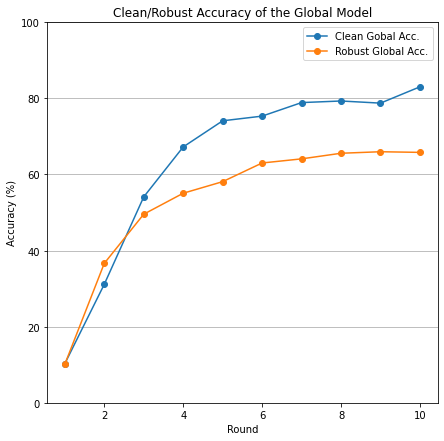

In [39]:
# global_acc_list = [26.716984038791264, 60.15311546396437, 73.3554127190271, 77.58730917267368, 80.73023665495782, 80.09354952848075,  81.32439079295223]

import matplotlib.pyplot as plt

num_round_list = list(range(1, num_rounds+1))
# glob_acc_list = [i*100 for i in glob_acc_list]

ymin = 0
ymax = 100

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.gca().set_ylim([ymin, ymax])
plt.title("Clean/Robust Accuracy of the Global Model")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")

plt.plot(num_round_list, glob_acc_list, '-o', label='Clean Gobal Acc.')
plt.plot(num_round_list, robust_acc_list, '-o', label='Robust Global Acc.')
plt.legend()

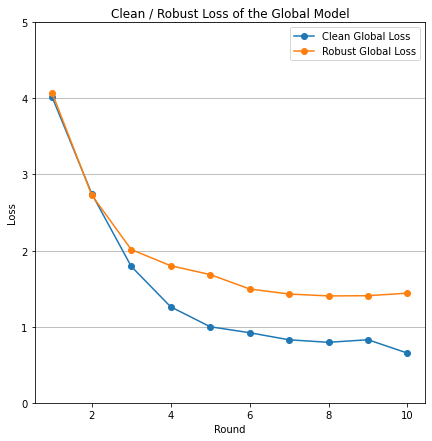

In [40]:
import matplotlib.pyplot as plt

num_round_list = list(range(1, num_rounds+1))

ymax = 5
ymin = 0

plt.figure(figsize=(7, 7))
plt.grid(axis='y')

plt.gca().set_ylim([ymin, ymax])
plt.title("Clean / Robust Loss of the Global Model")
plt.xlabel("Round")
plt.ylabel("Loss")

plt.plot(num_round_list, glob_loss_list, '-o', label='Clean Global Loss')
plt.plot(num_round_list, robust_loss_list, '-o', label='Robust Global Loss')
plt.legend()

In [41]:
# import matplotlib.pyplot as plt

# total_iter_per_client = num_local_epochs * num_rounds
# client_id_list = list(range(0, num_clients))
# total_iter_list = list(range(1, total_iter_per_client+1))

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')
# plt.title("Average Loss of each client")
# plt.xlabel("Iteration")
# plt.ylabel("Loss of each client")

# for client_id in client_id_list:
#     plt.plot(total_iter_list, id_loss_dict[client_id], label=("Client_id={}".format(client_id)))
#     plt.legend()

In [31]:
# import matplotlib.pyplot as plt

# total_iter_per_client = num_local_epochs * num_rounds
# client_id_list = list(range(0, num_clients))
# total_iter_list = list(range(1, total_iter_per_client+1))

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')
# plt.title("Average Accuracy of each client")
# plt.xlabel("Num rounds")
# plt.ylabel("Accuracy (%)")

# for client_id in client_id_list:
#     plt.plot(total_iter_list, id_acc_dict[client_id], label=("Client_id={}".format(client_id)))
#     plt.legend()

## 5.1 Global Accuracy per Each Proportion

In [32]:
# import matplotlib.pyplot as plt

# total_num_client = [5, 10, 15, 20]
# glob_acc_list = [82.5, 79.6, 73.2, 70.0]

# ymax = 100
# ymin = 0
# xmax = 21
# xmin = 5

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')

# plt.gca().set_xlim([xmin, xmax])
# plt.gca().set_ylim([ymin, ymax])
# plt.title("Global Accuracy when 80% of Clients Chosen Every Round")
# plt.xlabel("Total No. of Clients")
# plt.ylabel("Global Accuracy (%)")

# plt.plot(total_num_client, glob_acc_list, '-o')
# plt.legend()

In [33]:
# import matplotlib.pyplot as plt

# total_num_client = [6, 8, 16, 20]
# glob_acc_list = [78.6, 76.1, 61.5, 57.0]

# ymax = 100
# ymin = 0

# xmax = 21
# xmin = 5

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')

# plt.gca().set_xlim([xmin, xmax])
# plt.gca().set_ylim([ymin, ymax])
# plt.title("Global Accuracy when 50% of Clients Chosen Every Round")
# plt.xlabel("Total No. of Clients")
# plt.ylabel("Global Accuracy (%)")

# plt.plot(total_num_client, glob_acc_list, '-o')
# plt.legend()

In [34]:
# import matplotlib.pyplot as plt

# total_num_client = [5, 10, 15, 20]
# glob_acc_list = [71.8, 48.5, 40.8, 34.1]

# ymax = 100
# ymin = 0

# xmax = 21
# xmin = 5

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')

# plt.gca().set_ylim([xmin, xmax])
# plt.gca().set_ylim([ymin, ymax])
# plt.title("Global Accuracy when 20% of Clients Chosen Every Round")
# plt.xlabel("Total No. of Clients")
# plt.ylabel("Global Accuracy (%)")

# plt.plot(total_num_client, glob_acc_list, '-o')
# plt.legend()

## 6. Standard and Robust Accuracy

### 6.1 Standard Accuracy

In [43]:
# atk = FGSM(model, eps=8/255)
torch.cuda.empty_cache()
global_model.eval()
criterion = nn.CrossEntropyLoss()

total = 0
glob_loss = 0
glob_acc = 0
correct = 0

tq_batch = tqdm(test_loader, total=len(test_loader), leave=False)
for images, labels in tq_batch:
    images = images.to(device)
    labels = labels.to(device)

    outputs = global_model(images)
    loss = criterion(outputs, labels)
    glob_loss += loss.item()

    _, preds = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (preds == labels).sum()

    glob_acc += float(correct) / total
    batch_acc = float(correct) / total

    tq_batch.set_postfix_str('Global loss = {:.4f} ; Global acc = {:.4f} '.format(loss.item(), batch_acc))

# Average global loss and acc of the batch
glob_loss = glob_loss / len(test_loader)
glob_acc = glob_acc / len(test_loader)

print("Global loss: ", glob_loss)
print("Global accuracy: {} %".format(glob_acc*100))

  0%|          | 0/83 [00:00<?, ?it/s]

Global loss:  0.6532196111707802
Global accuracy: 83.03663323309608 %


### 6.2 Robust Accuracy

In [44]:
# white_model = white_box_model(num_classes=num_classes).to(device)
white_model = models.alexnet(pretrained=True).to(device)

atk_list = [
    FGSM(white_model, eps=8/255),
#     BIM(white_model, eps=8/255, alpha=100, steps=100),
#     RFGSM(white_model, eps=8/255, alpha=2/255, steps=100),
#     CW(white_model, c=1, lr=0.01, steps=100, kappa=0),
#     PGD(white_model, eps=8/255, alpha=2/225, steps=10, random_start=True),
#     PGDL2(white_model, eps=1, alpha=0.2, steps=100),
#     EOTPGD(white_model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(white_model, eps=8/255, alpha=10/255), # *
#     TPGD(white_model, eps=8/255, alpha=2/255, steps=100),
#     MIFGSM(white_model, eps=8/255),
#     VANILA(white_model),
#     FAB(white_model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
#     FAB(white_model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(white_model, eps=8/255, n_queries=2000, n_restarts=1, loss='ce'), # *
#     OnePixel(white_model, pixels=5, inf_batch=50),
#     DeepFool(white_model, steps=10),
#     DIFGSM(white_model, eps=8/255, alpha=2/255, steps=10, diversity_prob=0.5, resize_rate=0.9)
#     DIFGSM(white_model, eps=8/255)
]

torch.cuda.empty_cache()
global_model.eval()
criterion = nn.CrossEntropyLoss()

total = 0
glob_loss = 0
glob_acc = 0
correct = 0

# tq_batch = tqdm(test_loader, total=len(test_loader))

for atk in tqdm(atk_list):
    print("")
    print("*"*100)
    print(atk)
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Attack the model
        images = atk(images, labels)

        outputs = global_model(images)
        loss = criterion(outputs, labels)
        glob_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (preds == labels).sum()

        glob_acc += float(correct) / total
        batch_acc = float(correct) / total

        # tq_batch.set_postfix_str('Robust loss = {:.4f} ; Robust acc = {:.4f} '.format(loss.item(), batch_acc))

    # Average global loss and acc of the batch
    glob_loss = glob_loss / len(test_loader)
    glob_acc = glob_acc / len(test_loader)
    
    print("Robust loss: ", glob_loss)
    print("Robust accuracy: {}%".format(glob_acc*100))
    print("*"*100)
    print("")

  0%|          | 0/3 [00:00<?, ?it/s]


****************************************************************************************************
FGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, attack_mode=default, return_type=float)


  0%|          | 0/83 [00:00<?, ?it/s]

Robust loss:  1.4750131835420448
Robust accuracy: 64.91610631681007%
****************************************************************************************************


****************************************************************************************************
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)


  0%|          | 0/83 [00:00<?, ?it/s]

Robust loss:  1.462430036773978
Robust accuracy: 65.0018131842493%
****************************************************************************************************


****************************************************************************************************
Square(model_name=AlexNet, device=cuda:0, norm=Linf, n_queries=2000, eps=0.03137254901960784, p_init=0.8, n_restarts=1, seed=0, verbose=False, loss=ce, rescale_schedule=True, attack_mode=default, return_type=float)


  0%|          | 0/83 [00:00<?, ?it/s]

Robust loss:  0.6708392501680571
Robust accuracy: 68.45363773791323%
****************************************************************************************************

